# "머신러닝을 통한 접근 가이드" 목차
## 1. Library
## 2. Data Loading
## 3. Feature Engineering
### 3-1. Feature Generation
#### CODE SHARE WITH "파베르"님 
#### (https://dacon.io/competitions/official/235745/codeshare/2851?page=1&dtype=recent)
### 3-2. Feature Engineering
#### 3-2-1. Encoding
#### 3-2-2. Scailing
## 4. Modeling with Pycaret
## 5. Modeling with CatBoostRegressor

## 1. Library

In [2]:
# for "2. Data Loading"
import pandas as pd

# for "3-1. Feature Generation"
import numpy as np

# for "3-2. Feature Engineering"
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import RobustScaler, StandardScaler

# for "4. Modeling with Pycaret"
from pycaret.regression import *

# for "5. Modeling with CatBoostRegressor"
from catboost import CatBoostRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold

## 2. Data Loading

In [3]:
train = pd.read_csv('G:\내 드라이브\Github\Dacon-practice\주차수요 예측 AI/train.csv')
test = pd.read_csv('G:\내 드라이브\Github\Dacon-practice\주차수요 예측 AI/test.csv')

## 3. Feature Engineering

### 3-1. Feature Generation
#### CODE SHARE WITH "파베르"님 
#### (https://dacon.io/competitions/official/235745/codeshare/2851?page=1&dtype=recent)
##### Feature Generation과 관련된 EDA는 위의 링크를 참조해주세요 :) 

In [10]:
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train.임대료=='-', '임대료'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].fillna(0)
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna(0)

cols = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)

#### (3) 자격유형

test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

train = train.drop_duplicates()
test = test.drop_duplicates()

unique_cols = ['총세대수', '지역', '공가수', 
               '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
               '도보 10분거리 내 버스정류장 수',
               '단지내주차면수', '등록차량수']
train_agg = train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns})
    return res

train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
train.loc[train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
test.loc[test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'

train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

X_train = pd.concat([train_agg,
                       reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='자격유형', value_col='counter')], axis=1)

X_test = pd.concat([test_agg,
                       reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='자격유형', value_col='counter')], axis=1)

### 3-2. Feature Engineering
- 필요성?

In [11]:
X_train.head(3)

# 1. 지역은 글자데이터이다.
## 한글은 Catboost 이외에는 받아들일 수 없기  때문에, Encoding 과정이 필요하다.
## 해결법  : 통계치를 반영한 Encoding과, One-Hot Encoding 모두 적용해준다.

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
단지코드,,,,,,,,,,,,,,,,,,,,
C2483,900,경상북도,38.0,0.0,3.0,1425.0,1015.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [12]:
X_train.describe()

# 2. 단위가 다르다.
## 총 세대수, 공가수는 "세대 수"를, "도보 ~~"는 근처의 "개수"를, "단지내주차면수"는 "면적"을 의미하는 등 의미하는 바가 다르다.
## 이 경우에는, Feature의 "Scale"을 동일하게 해주지 않으면 Machine Learning과정에서 가중치 학습에 있어서 오류가 있을 수 있다.
## 해결법 : Robust Scailing을 적용해준다. (Good for outliers)

# 3. 이상치가 보인다.
## "도보 10분 거리 내 버스정류장 수"를 확인하면, 75%까지는 4이나, max는 20인 것을 확인할 수 있다.
## "도보 10분 거리 내 지하철역~`"은 75%까지는 0이지만, max는 3인 것을 확인할 수 있다.
## 이상치는 Linear Regression Model에서 상대적으로 큰 영향력을 끼친다.
## 해결법 : 데이터를 살펴보고, 처리를 결정한다.

# 4. 의미 없는 Feature도 확인되었다.
## "임대건물구분_아파트"의 경우 모두가 1이다.
## 해결법 : 단순 제거해준다.

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
count,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.0,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000
mean,722.387707,13.479905,0.120567,3.690307,592.744681,572.335697,0.078014,1.0,0.026005,0.089835,0.742317,0.132388,0.078014,0.073286,0.784870,0.080378,0.115839,0.130024,0.073286
std,405.590274,10.385414,0.379733,2.808429,367.655143,391.032563,0.268511,0.0,0.159338,0.286283,0.437877,0.339313,0.268511,0.260914,0.411399,0.272200,0.320411,0.336728,0.260914
min,26.000000,0.000000,0.000000,0.000000,13.000000,13.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,447.500000,5.000000,0.000000,2.000000,319.500000,295.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,632.000000,13.000000,0.000000,3.000000,523.000000,505.000000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,923.000000,20.000000,0.000000,4.000000,803.000000,762.500000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2568.000000,55.000000,3.000000,20.000000,1798.000000,2550.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
X_train = X_train.drop(columns = ['임대건물구분_아파트'])
X_test = X_test.drop(columns = ['임대건물구분_아파트'])

- 필요성 - 3. 이상치가 보인다

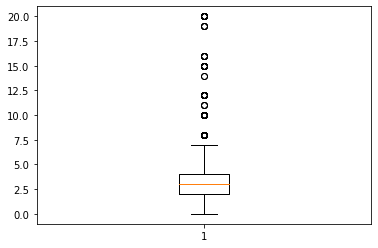

In [13]:
plt.boxplot([train['도보 10분거리 내 버스정류장 수']])
plt.show()

# 20에 가까운 값들이 존재하지만, 따로 처리해주기에는 독립적으로 떨어진 분포가 아니기 때문에, 제거하지 않는다.

In [14]:
display('Train Data')
display(X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))
display('='*50)
display('Test Data')
display(X_test.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))
display('='*50)
# 지하철 역 수가 3인 데이터는 제거한다.

display('After Engineering')
X_train = X_train[X_train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] != 3]
display(X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))

'Train Data'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    379
1.0     38
2.0      5
3.0      1
Name: 총세대수, dtype: int64

'=================================================='

'Test Data'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    139
1.0      8
2.0      3
Name: 총세대수, dtype: int64

'=================================================='

'After Engineering'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    379
1.0     38
2.0      5
Name: 총세대수, dtype: int64

#### 3-2-1. Encoding

In [15]:
%%time
encoding_features = ['지역', '도보 10분거리 내 지하철역 수(환승노선 수 반영)']
for f in encoding_features:
    mapping = X_train.groupby([f])['등록차량수'].agg(['mean','median','std'])
    mapping_values = []
    for l in X_train[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_train.index)
    X_train = pd.concat([X_train,bincount], axis= 1).drop(columns = [f])

    mapping_values = []
    for l in X_test[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_test.index)
    X_test = pd.concat([X_test,bincount], axis= 1).drop(columns = [f])

Wall time: 193 ms


#### 3-2-2. Scailing

In [16]:
scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '지역_mean', 
                     '지역_median',
                     '지역_std', 
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
                   '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
                   '도보 10분거리 내 지하철역 수(환승노선 수 반영)_std'
                    ]

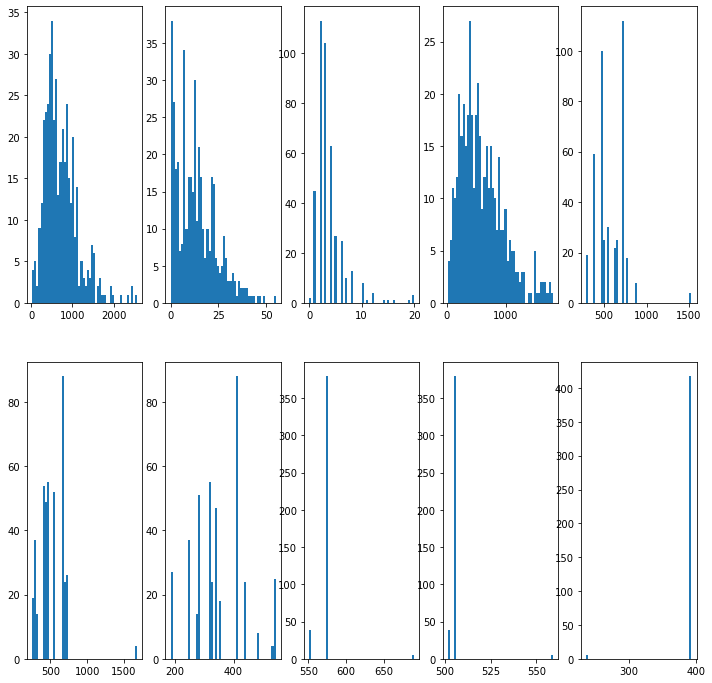

In [17]:
fig, axes = plt.subplots(2,5, figsize= (12,12))

i = 0
for f in scailing_features:
    c = i % 5
    r = i // 5
    
    axes[r,c].hist(x = f, bins =50, data = X_train)
    i += 1
plt.show()


# 지역은 이상치가 확인 => Robust Scailing
# 도보 -> std 제거
# 나머지는 Standard

In [18]:
# 도보 10분거리 std는 그림상 의미가 없기에 Drop
X_train = X_train.iloc[:,:-1]
X_test = X_test.iloc[:,:-1]

In [19]:
# 지역은  Scailing

scaler = RobustScaler()
loc_f = [    '지역_mean', 
             '지역_median',
             '지역_std', ]
X_train.loc[:, loc_f] = scaler.fit_transform(X_train[loc_f])
X_test.loc[:, loc_f] = scaler.transform(X_test[loc_f])

In [20]:
# 나머지 Scailing
scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
                       '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
                    ]

scaler = StandardScaler()
X_train.loc[:, scailing_features] = scaler.fit_transform(X_train[scailing_features])
X_test.loc[:, scailing_features] = scaler.transform(X_test[scailing_features])

## 4. Modeling with pycaret

In [23]:
reg = setup(X_train, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.999,  # 우리는 전체 데이터를 학습해 test를 예측하는게 목표이기 때문에, 0.999로 설정한다.
            target = '등록차량수', # 목표 변수는 등록 차량 수 이다.
            silent = True, # 엔터를 누르기 귀찮다. 궁금하면 풀어보세요
            use_gpu = True, # GPU가 있으면 사용하세요 (Cat BOost 속도 향상)
            numeric_features=list(X_train.drop(columns = ['등록차량수']).columns), # 모든 변수가 숫자로써의 의미가 있다.
            session_id = 2021,
            fold_shuffle = True
            )

,Description,Value
0,session_id,2021
1,Target,등록차량수
2,Original Data,"(422, 23)"
3,Missing Values,False
4,Numeric Features,22
5,Categorical Features,0
6,Transformed Train Set,"(421, 22)"
7,Transformed Test Set,"(1, 22)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


- Top5의 모델 선택

In [ ]:
top5 = compare_models(n_select = 5, sort = 'MAE')

IntProgress(value=0, description='Processing: ', max=94)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:06:32
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
par,Passive Aggressive Regressor,126.2411,33825.4750,180.7609,0.7664,0.4501,0.3725,0.0130
huber,Huber Regressor,126.5377,33206.7760,179.7857,0.7674,0.4064,0.3636,0.0500
br,Bayesian Ridge,127.7621,34035.5342,182.3251,0.7599,0.4352,0.3557,0.0130
llar,Lasso Least Angle Regression,127.9068,34727.1600,183.1723,0.7592,0.4076,0.3883,0.0200
ridge,Ridge Regression,127.9770,33995.0447,182.2432,0.7600,0.4410,0.3584,0.0130
lasso,Lasso Regression,128.0406,33796.4836,181.6456,0.7618,0.4290,0.3545,0.0130
lr,Linear Regression,128.8471,34048.5217,182.3509,0.7598,0.4525,0.3649,0.0180
rf,Random Forest Regressor,129.1638,37222.5284,190.5662,0.7335,0.3693,0.3285,0.5610
gbr,Gradient Boosting Regressor,129.2924,36738.7833,189.4987,0.7358,0.3948,0.3450,0.1100
et,Extra Trees Regressor,133.0901,39604.2018,195.4607,0.7218,0.3705,0.3277,0.5140


- Top5 Model Tuning

In [38]:
models = []
for m in top5:
    models.append(tune_model(m, 
                             optimize = 'MAE', 
                             choose_better = True,
                            n_iter = 30))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,137.6468,37020.5688,192.4073,0.7481,0.4541,0.4438
1,128.0844,32811.3159,181.1389,0.7957,0.4916,0.4016
2,152.6467,41475.4527,203.6552,0.7335,0.4716,0.4308
3,128.6503,30093.5087,173.4748,0.8090,0.4945,0.2738
4,116.1586,22839.0155,151.1258,0.7900,0.3326,0.2772
5,142.9697,43961.5214,209.6700,0.7688,0.3738,0.3014
6,104.8041,24934.7469,157.9074,0.7802,0.3209,0.3180
7,146.0295,55390.3075,235.3515,0.7936,0.3172,0.2428
8,115.7977,28570.6767,169.0286,0.6818,0.4887,0.3534
9,100.0117,17240.6193,131.3035,0.7514,0.5026,0.5109


In [43]:
voting = blend_models(models, optimize = 'MAE')
voting = tune_model(voting, 
                 optimize = 'MAE', 
                 choose_better = True,
                 n_iter = 30)

voting = finalize_model(voting)
sample = pd.read_csv('../data/sample_submission.csv')
layer1_pred = voting.predict(X_test)
sample['num'] = layer1_pred
sample.to_csv('../submissions/pycaret.csv', index=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,132.6476,31477.1061,177.4179,0.7858,0.5078,0.5249
1,117.7659,31163.7939,176.5327,0.8060,0.4222,0.3775
2,149.4243,42548.7789,206.2736,0.7266,0.4315,0.3836
3,120.2428,26984.6640,164.2701,0.8287,0.2859,0.2300
4,114.9347,21833.2350,147.7607,0.7992,0.3065,0.2607
5,138.1074,46180.5464,214.8966,0.7571,0.3599,0.2899
6,103.5794,25140.0749,158.5562,0.7784,0.3184,0.2530
7,140.6045,54329.7469,233.0874,0.7976,0.2736,0.2218
8,114.3241,29370.1914,171.3773,0.6729,0.3845,0.3571
9,95.1483,16619.2600,128.9157,0.7604,0.4952,0.5207


# Modeling with Gradient Boosting Regressor

- Setting Data For Model

In [55]:
X = X_train.drop(columns = ['등록차량수'])
y = X_train['등록차량수']

- Hyper params Tuning

In [96]:
def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 42,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "verbose" : 1,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)

    model = CatBoostRegressor(**params_cat)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False,
    )

    cat_pred = model.predict(X_val)
    log_score = mean_absolute_error(y_val, cat_pred)
    
    return log_score

In [97]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-07-22 14:01:05,605] A new study created in memory with name: cat_opt
[I 2021-07-22 14:01:06,085] Trial 0 finished with value: 104.62083663715474 and parameters: {'max_depth': 6, 'colsample_bylevel': 0.9901428612819833, 'subsample': 0.8123957592679836, 'min_child_samples': 62, 'max_bin': 246}. Best is trial 0 with value: 104.62083663715474.
[I 2021-07-22 14:01:06,263] Trial 1 finished with value: 134.56181465539058 and parameters: {'max_depth': 3, 'colsample_bylevel': 0.8116167224336399, 'subsample': 0.9063233020424546, 'min_child_samples': 62, 'max_bin': 413}. Best is trial 0 with value: 104.62083663715474.
[I 2021-07-22 14:01:06,376] Trial 2 finished with value: 128.00850077473459 and parameters: {'max_depth': 1, 'colsample_bylevel': 0.9939819704323989, 'subsample': 0.8827098485602951, 'min_child_samples': 25, 'max_bin': 254}. Best is trial 0 with value: 104.62083663715474.
[I 2021-07-22 14:01:06,745] Trial 3 finished with value: 134.74533209138502 and parameters: {'max_depth'

Best Score: 104.62083663715474
Best trial: {'max_depth': 6, 'colsample_bylevel': 0.9901428612819833, 'subsample': 0.8123957592679836, 'min_child_samples': 62, 'max_bin': 246}


In [98]:
cat_p = study.best_trial.params
cat = CatBoostRegressor(**cat_p)

- StratifiedK-Fold for Regression

In [105]:
y_cat = pd.cut(y, 10, labels=range(10))
skf = StratifiedKFold(5)

preds = []
for tr_id, val_id in skf.split(X, y_cat) : 
    X_tr = X.iloc[tr_id]
    y_tr = y.iloc[tr_id]
    
    cat.fit(X_tr, y_tr, verbose = 0)
    
    pred = cat.predict(X_test)
    preds.append(pred)
cat_pred = np.mean(preds, axis = 0)

In [106]:
sample = pd.read_csv('../data/sample_submission.csv')
sample['num'] = cat_pred
sample.to_csv('../submissions/cat.csv', index=False)